**数据处理**

In [1]:
from __future__ import unicode_literals, division
import glob
import unicodedata
import string
from io import open
import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import time
import math

def find_files(path):
    '''查到当前路径下所有的文件
    Args:
        path: 路径，可以是一种匹配模式，如*.txt
    '''
    return glob.glob(path)

src_path = 'data/names/*.txt'
files = find_files(src_path)
print (files)
# a-zA-Z .;'
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print ('n_letters:', n_letters)

def unicodeToAscii(s):
    '''unicode to ascii'''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

[u'data/names/Arabic.txt', u'data/names/Chinese.txt', u'data/names/Czech.txt', u'data/names/Dutch.txt', u'data/names/English.txt', u'data/names/French.txt', u'data/names/German.txt', u'data/names/Greek.txt', u'data/names/Irish.txt', u'data/names/Italian.txt', u'data/names/Japanese.txt', u'data/names/Korean.txt', u'data/names/Polish.txt', u'data/names/Portuguese.txt', u'data/names/Russian.txt', u'data/names/Scottish.txt', u'data/names/Spanish.txt', u'data/names/Vietnamese.txt']
(u'n_letters:', 57)
Slusarski


**读取文件**

In [2]:
all_categories = []
category_lines = {}
def read_lines(filename):
    '''读取filename中的内容，一行一行，转换为ascii码'''
    # io.open
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in files:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print ('n_categories:', n_categories)
print(category_lines['Chinese'][:5])

(u'n_categories:', 18)
[u'Ang', u'AuYong', u'Bai', u'Ban', u'Bao']


**NameToTensor**

In [3]:
def letter_to_index(letter):
    '''字母的编号'''
    return all_letters.find(letter)

def letter_to_tensor(letter):
    '''字符转成Tensor'''
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    '''单词转Tensor, (len(line), 1, n_letters), 1是batchsize=1
    Args:
        line: 一个人名
    '''
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx][0][letter_to_index(letter)] = 1
    return tensor

print (line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


**构建网络**

In [4]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        # 两个线性回归
        self.i2o = nn.Linear(input_dim + hidden_dim, output_dim)
        self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        '''前向计算
        Args:
            input: 单个字符的编码，即[1, n_letters]矩阵
            hidden: 上一个状态的hidden，即[1, hidden_dim]矩阵
        Returns:
            output: 当前的输出，这里是(1, n_categories)向量
            hidden: 当前的隐状态
        '''
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_dim))

n_hidden = 128
print ('Net:', n_letters, n_hidden, n_categories)
rnn = RNN(n_letters, n_hidden, n_categories)

# 测试
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))
# print (input[0])
output, next_hidden = rnn(input[0], hidden)
print ('input[0]:', input[0].size(), 'hidden:', hidden.size(), type(input[0]))
a = torch.cat((input[0], hidden), 1)
print (a.size())
print ('output:', output.size(), output)
# 用topk可以返回(values,indices)
print ('max:', output.data.max())

def category_from_output(output):
    '''从output中得到具体的category
    Args:
        output: 网路的输出[1, n_categories]向量。是1个Tensor
    Returns:
        category_name和category_idx下标
    '''
    # 都是1*1的
    values, indics = output.data.topk(1)
    category_idx = indics[0][0]
    return all_categories[category_idx], category_idx
print (category_from_output(output))

(u'Net:', 57, 128, 18)
(u'input[0]:', torch.Size([1, 57]), u'hidden:', torch.Size([1, 128]), <class 'torch.autograd.variable.Variable'>)
torch.Size([1, 185])
(u'output:', torch.Size([1, 18]), Variable containing:

Columns 0 to 9 
-2.8057 -2.8979 -2.9337 -2.9630 -2.8497 -2.9256 -2.8806 -2.9512 -2.9468 -2.9181

Columns 10 to 17 
-2.9732 -2.8373 -2.8623 -2.9667 -2.8157 -2.8652 -2.7905 -2.8725
[torch.FloatTensor of size 1x18]
)
(u'max:', -2.790452480316162)
(u'Spanish', 16)


**准备训练数据**

In [5]:
def random_choice(la):
    ''' 从列表中随机选择一个值
    Args:
        la: 列表
    Returns:
        value: 所选择的值
    '''
    idx = random.randint(0, len(la) - 1)
    return la[idx]

def random_training_example():
    '''随机产生训练数据'''
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_idx = all_categories.index(category)
    # 类别是LongTensor
    category_tensor = Variable(torch.LongTensor([category_idx]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    #print (category, ':', line)
    #print (category_tensor.size(), line_tensor.size())

**训练网络**

In [13]:
loss_func = nn.NLLLoss()
learning_rate = 0.005
category, line, category_tensor, line_tensor = random_training_example()
#print (output.size(), category_tensor.size(), category_tensor.data)
loss = loss_func(output, category_tensor)
#print (loss)
def train(category_tensor, line_tensor):
    ''' 一次训练
    Args:
        category_tensor: 类别的idx
        line_tensor: 一个单词的编码，即(len, 1, n_letters)矩阵
    '''
    # 初始hidden和grad
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    # 依次输入每个字母，更新hidden
    for i in range(line_tensor.size()[0]):
#         print (line_tensor[i].size(), type(line_tensor[i]))
#         print (hidden.size(), type(hidden))
#         combined = torch.cat((line_tensor[i], hidden), 1)
#         print (combined)
        output, hidden = rnn(line_tensor[i], hidden)
    # 计算loss
    # (预测的，真实的)=(Input, target)=(N,C), (N)
    loss = loss_func(output, category_tensor)
    loss.backward()
    
    # 更新参数
    for p in rnn.parameters():
        p.data.add_(-learning_rate * p.grad.data)
    return output, loss.data[0]

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print 'start'
for i in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if i % print_every == 0:
        c_pred, cpred_idx = category_from_output(output)
        correct = 'True'
        if category != c_pred:
            correct = 'False (%s)' % category
        print ('%d %d%% (%s) %.4f, %s / %s (%s)' 
               % (i, i / n_iters * 100, time_since(start), loss, line, c_pred, correct)
              )
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
print ('end')

start
5000 5% (0m 18s) 4.2377, Paulis / Greek (False (German))
10000 10% (0m 36s) 1.2928, Vestri / Italian (True)
15000 15% (0m 54s) 1.1227, Quyen / Vietnamese (True)
20000 20% (1m 12s) 1.8031, Issa / Japanese (False (Arabic))
25000 25% (1m 30s) 0.3457, Milligan / Irish (True)
30000 30% (1m 48s) 2.0461, Adsit / Scottish (False (Czech))
35000 35% (2m 6s) 1.8947, Ormsby / Scottish (False (English))
40000 40% (2m 24s) 1.2948, Jackson / Scottish (True)
45000 45% (2m 42s) 0.4915, Campbell / Scottish (True)
50000 50% (2m 59s) 0.9746, Kenkyusha / Japanese (True)
55000 55% (3m 16s) 0.9119, Piontek / Polish (True)
60000 60% (3m 33s) 1.9345, Mahoney / Arabic (False (Irish))
65000 65% (3m 51s) 0.1679, Demakis / Greek (True)
70000 70% (4m 8s) 0.9829, Martin / Scottish (True)
75000 75% (4m 26s) 0.2461, Ta / Vietnamese (True)
80000 80% (4m 44s) 1.4209, Shepherd / Dutch (False (English))
85000 85% (5m 2s) 1.8468, Sokal / Scottish (False (Polish))
90000 90% (5m 20s) 1.3280, Murygin / Irish (False (Rus

**plot loss**

100


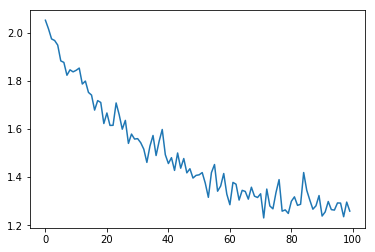

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
print len(all_losses)
plt.figure()
plt.plot(all_losses)

**评估模型**
混合矩阵来评估

In [22]:
# 每个类别预测为别的类别的个数
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    '''得到line的分类结果'''
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# 去记录
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    c_pred, c_pred_i = category_from_output(output)
    category_i = all_categories.index(category)
    # category_i 预测为 c_pred_i的数量+1
    confusion[category_i][c_pred_i] += 1

# 归一化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
print(confusion[0])



 0.7686
 0.0231
 0.0050
 0.0099
 0.0000
 0.0000
 0.0033
 0.0364
 0.0314
 0.0132
 0.0727
 0.0050
 0.0000
 0.0231
 0.0000
 0.0033
 0.0000
 0.0050
[torch.FloatTensor of size 18]



**画图表示confusion**

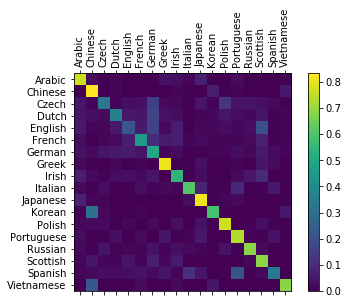

In [28]:
# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# axes x-0真实的，y-1预测的
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# force label at every tick，否则只会隔几个显示一下
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

**预测**

In [34]:
def predict(name, n_predictions = 3):
    '''输入一个姓名，进行预测'''
    print ('\n > %s' % name)
    output = evaluate(Variable(line_to_tensor(name)))
    # 都是1*1的
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    for i in range(n_predictions):
        prob = topv[0][i]
        c_pred_i = topi[0][i]
        c_pred = all_categories[c_pred_i]
        print ('(%.2f) %s' % (prob, c_pred))
        predictions.append([prob, c_pred])
predict('ZhangJie')
predict('Qiang')
predict('WangJie')
predict('Carmelo')
predict('Dovesky')
predict('Jackson')


 > ZhangJie
(-1.37) Scottish
(-1.40) Russian
(-2.27) Japanese

 > Qiang
(-0.89) Chinese
(-1.01) Irish
(-3.15) Vietnamese

 > WangJie
(-0.66) Scottish
(-1.74) English
(-2.53) Russian

 > Carmelo
(-0.94) Scottish
(-1.33) Spanish
(-1.80) Italian

 > Dovesky
(-0.44) Russian
(-1.64) Czech
(-2.58) English

 > Jackson
(-0.28) Scottish
(-2.44) English
(-2.69) Russian


**API总结**

In [134]:
'''1. randn和arange'''
x = torch.randn(1, 1)  # 1个数, [1,1]
#print (x.size())
x = torch.arange(1, 6) # 5个数 [5]
print (x.size())
'''2. topk和max'''
# topk 返回的是(values, indics)
values, indics = x.topk(1)
print (values)
print (indics)
# x.max() 会返回最大值，但是不会返回索引
'''3. randint'''
#[1,2]之间选择
print (random.randint(1, 2))
'''4. NLLLoss'''
m = nn.LogSoftmax()
loss_func = nn.NLLLoss()
# input (n_batch, n_classes)
inputs = Variable(torch.randn(3, 5), requires_grad = True)
# 对应的类别，输入下标即可
target = Variable(torch.LongTensor([1, 0, 4]))
loss = loss_func(m(inputs), target)
print (loss)
loss.backward()


torch.Size([5])

 5
[torch.FloatTensor of size 1]


 4
[torch.LongTensor of size 1]

1
Variable containing:
 1.8314
[torch.FloatTensor of size 1]

